In [194]:
import os
import sys
import torch
import transformers
import tqdm
import random
import json
import matplotlib.pyplot as plt
import scipy
import logging
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, GPTNeoXTokenizerFast, GPTNeoXForCausalLM

In [2]:
class Surprisal:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

        self.model.eval()

    def evaluate(sent):
        token_ids = self.tokenizer.encode(sent)
        
        with torch.no_grad():
            output = model(token_ids)
        softmax = torch.nn.Softmax(dim=-1) 
        return softmax(output.logits).squeeze(0)

In [36]:
def generate_stories(language):
    stories = []
    for a, b, c in os.walk('ud-215/ud-treebanks-v2.15'):
        if language in a:
            for f in c:
                if any(map(lambda i: f.endswith(i), ['dev.txt', 'test.txt', 'train.txt'])):
                    stories.extend(open(f'{a}/{f}').read().split("\n\n"))
    return stories

In [30]:
AutoTokenizer.from_pretrained("surajp/gpt2-hindi")

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/597 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/751k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

GPT2TokenizerFast(name_or_path='surajp/gpt2-hindi', vocab_size=50257, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50257: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [192]:
AutoTokenizer.from_pretrained("flax-community/swe-gpt-wiki")

tokenizer_config.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/855k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/513k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.47M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

GPT2TokenizerFast(name_or_path='flax-community/swe-gpt-wiki', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50265: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [193]:
def calculate_surprisal(model_variant, mode, language):
    stories = generate_stories(language)
    try:
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_variant, use_fast=False)#, from_flax=True)
            model = AutoModelForCausalLM.from_pretrained(model_variant)#, from_flax=True)
        except Exception as e:
            tokenizer = AutoTokenizer.from_pretrained(model_variant, use_fast=False, from_tf=True)
            model = AutoModelForCausalLM.from_pretrained(model_variant, from_tf=True)
    except Exception as e:
        tokenizer = AutoTokenizer.from_pretrained(model_variant, use_fast=False, from_flax=True)
        model = AutoModelForCausalLM.from_pretrained(model_variant, from_flax=True)

    model.eval()
    softmax = torch.nn.Softmax(dim=-1)
    ctx_size = model.config.max_position_embeddings
    bos_id = model.config.bos_token_id

    batches = []
    words = []
    vocab_size = model.config.vocab_size
    for story in tqdm.tqdm(stories):#, position=1):
        words.extend(story.split(" "))
        tokenizer_output = tokenizer(story)
        ids = tokenizer_output.input_ids
        ids = [id_val if id_val < vocab_size else tokenizer.unk_token_id for id_val in ids]
        attn = tokenizer_output.attention_mask

        # these tokenizers do not append bos_id by default
        if "gpt" in model_variant or "pythia" in model_variant:
            ids = [bos_id] + ids
            attn = [1] + attn

        start_idx = 0

        # sliding windows with 50% overlap
        # start_idx is for correctly indexing the "later 50%" of sliding windows
        while len(ids) > ctx_size:
            # for models that explicitly require the first dimension (batch_size)
            if "gpt-neox" in model_variant or "pythia" in model_variant or "opt" in model_variant:
                batches.append((transformers.BatchEncoding({"input_ids": torch.tensor(ids[:ctx_size]).unsqueeze(0),
                                                            "attention_mask": torch.tensor(attn[:ctx_size]).unsqueeze(0)}),
                                torch.tensor(ids[1:ctx_size+1]), start_idx, True))
            # for other models
            else: #elif "gpt" in model_variant:
                batches.append((transformers.BatchEncoding({"input_ids": torch.tensor(ids[:ctx_size]),
                                                            "attention_mask": torch.tensor(attn[:ctx_size])}),
                                torch.tensor(ids[1:ctx_size+1]), start_idx, True))

            ids = ids[int(ctx_size/2):]
            attn = attn[int(ctx_size/2):]
            start_idx = int(ctx_size/2)

        # remaining tokens
        if "gpt-neox" in model_variant or "pythia" in model_variant or "opt" in model_variant:
            batches.append((transformers.BatchEncoding({"input_ids": torch.tensor(ids[:-1]).unsqueeze(0),
                                                        "attention_mask": torch.tensor(attn[:-1]).unsqueeze(0)}),
                           torch.tensor(ids[1:]), start_idx, False))
        else: #elif "gpt" in model_variant:
            batches.append((transformers.BatchEncoding({"input_ids": torch.tensor(ids[:-1]),
                                                        "attention_mask": torch.tensor(attn[:-1])}),
                           torch.tensor(ids[1:]), start_idx, False))

    print("word llmsurp")
    
    curr_word_surp = []
    curr_toks = []
    curr_word_ix = 0
    is_continued = False
    count = 0
    total = 0
    for batch in tqdm.tqdm(batches):#random.sample(batches, min(5000, len(batches)))):#, position=1):
        try:
            # print("reading", batch)
            batch_input, output_ids, start_idx, will_continue = batch
    
            with torch.no_grad():
                model_output = model(**batch_input)
    
            toks = tokenizer.convert_ids_to_tokens(output_ids)
            index = torch.arange(0, output_ids.shape[0])
            surp = -1 * torch.log2(softmax(model_output.logits).squeeze(0)[index, output_ids])
    
            if mode == "token":
                # token-level surprisal
                for i in range(start_idx, len(toks)):
                    cleaned_tok = tokenizer.convert_tokens_to_string([toks[i]]).replace(" ", "")
                    # print(cleaned_tok, surp[i].item())
                    if total > 250:
                        continue
                    total += surp[i].item()
                    count += 1
                    # print(count, total)
    
            elif mode == "word":
                # word-level surprisal
                # if the batch starts a new story
                if not is_continued:
                    curr_word_surp = []
                    curr_toks = []
                for i in range(start_idx, len(toks)):
                    curr_word_surp.append(surp[i].item())
                    curr_toks += [toks[i]]
                    curr_toks_str = tokenizer.convert_tokens_to_string(curr_toks)
                    # summing token-level surprisal
                    # print(words[curr_word_ix], curr_toks_str.strip())
                    if words[curr_word_ix] == curr_toks_str.strip():
                        # print(curr_toks_str.strip(), sum(curr_word_surp))
                        count += 1
                        total += sum(curr_word_surp)
                        curr_word_surp = []
                        curr_toks = []
                        curr_word_ix += 1
                        # print(count, total)
    
            is_continued = will_continue
    
            del model_output
        except Exception as e:
            print("error reading batch", tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(output_ids)))
    # print(count, total)
    return total / count

# calculate_surprisal("surajp/gpt2-hindi", "token", "Hindi")
    

In [204]:
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='output-4.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

In [189]:
models = {i.split(":")[0]: i.split(":")[1] for i in open("models.txt").read().split("\n")[:-1]}

surprisals = {}

for lang, model in tqdm.tqdm(list(models.items())):
    # if lang in surprisals:
        # print("skipping", lang)
        # continue
    # lang = 'Armenian'
    model = models[lang]
    logger.info(f"starting {lang}")
    try:
    # word_surprisal = calculate_surprisal(model, "word", lang)
        token_surprisal = calculate_surprisal(model, "token", lang)
        surprisals[lang] = (word_surprisal, token_surprisal)
        
        with open(f"surprisals-4-{lang}.txt", "w") as f:
            # f.write(f"Word: {word_surprisal}\n")
            f.write(f"Token: {token_surprisal}\n")
        
        logger.info(f"finished {lang}")
    except Exception as e:
        logger.error(f"ERROR ON LANG {lang}")
        logger.error(f"[-] {e}")

starting Armenian


pytorch_model.bin:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.45G [00:00<?, ?B/s]


100%|█████████████████████████████████████| 4458/4458 [00:04<00:00, 1015.83it/s]


word llmsurp



100%|███████████████████████████████████████| 1000/1000 [23:01<00:00,  1.38s/it]


finished Armenian


In [70]:
flex_data = json.load(open("flexibility_ any.json", "r"))

In [71]:
flex_data

[{'label': ['Afrikaans/Indo-European-Germanic'],
  'data': [{'x': 0, 'y': 25.3, 'z': 0, 'r': 5, 'label': 'Afrikaans'}]},
 {'label': ['Akkadian/Semitic'],
  'data': [{'x': 0, 'y': 5.05, 'z': 0, 'r': 5, 'label': 'Akkadian'}]},
 {'label': ['Gheg/Indo-European'],
  'data': [{'x': 0, 'y': 20.67, 'z': 0, 'r': 5, 'label': 'Gheg'}]},
 {'label': ['Amharic/Afroasiatic'],
  'data': [{'x': 0, 'y': 21.45, 'z': 0, 'r': 5, 'label': 'Amharic'}]},
 {'label': ['Akuntsu/Tupian'],
  'data': [{'x': 0, 'y': 30.54, 'z': 0, 'r': 5, 'label': 'Akuntsu'}]},
 {'label': ['Arabic/Semitic'],
  'data': [{'x': 0, 'y': 9.03, 'z': 0, 'r': 5, 'label': 'Arabic'}]},
 {'label': ['Karo/Tupian'],
  'data': [{'x': 0, 'y': 16.65, 'z': 0, 'r': 5, 'label': 'Karo'}]},
 {'label': ['Belarusian/Indo-European-Baltoslavic'],
  'data': [{'x': 0, 'y': 25.78, 'z': 0, 'r': 5, 'label': 'Belarusian'}]},
 {'label': ['Beja/Afroasiatic'],
  'data': [{'x': 0, 'y': 31.12, 'z': 0, 'r': 5, 'label': 'Beja'}]},
 {'label': ['Bulgarian/Indo-European-Ba

In [72]:
flexibility = {i['data'][0]['label']: i['data'][0]['y'] for i in flex_data}

In [85]:
groups = {i['data'][0]['label']: i['label'][0].split("/")[1] for i in flex_data}
groups

{'Afrikaans': 'Indo-European-Germanic',
 'Akkadian': 'Semitic',
 'Gheg': 'Indo-European',
 'Amharic': 'Afroasiatic',
 'Akuntsu': 'Tupian',
 'Arabic': 'Semitic',
 'Karo': 'Tupian',
 'Belarusian': 'Indo-European-Baltoslavic',
 'Beja': 'Afroasiatic',
 'Bulgarian': 'Indo-European-Baltoslavic',
 'Bhojpuri': 'Indo-European',
 'Bambara': 'Niger-Congo',
 'Breton': 'Indo-European',
 'Buryat': 'Agglutinating',
 'Catalan': 'Indo-European-Romance',
 'Cebuano': 'Austronesian',
 'Chukot': 'Agglutinating',
 'Coptic': 'Afroasiatic',
 'Czech': 'Indo-European-Baltoslavic',
 'OldChurchSlavonic': 'Indo-European-Baltoslavic',
 'Welsh': 'Indo-European',
 'Danish': 'Indo-European-Germanic',
 'German': 'Indo-European-Germanic',
 'Greek': 'Indo-European',
 'Emerillon': 'Tupian',
 'English': 'Indo-European-Germanic',
 'Spanish': 'Indo-European-Romance',
 'Yupik': 'Eskimo–Aleut',
 'Estonian': 'Agglutinating',
 'Basque': 'isolate',
 'Persian': 'Indo-European',
 'Finnish': 'Agglutinating',
 'Faroese': 'Indo-Europe

In [77]:
surprisals = {}
for k in models.keys():
    try:
        surprisals[k] = float(open(f'surprisals-3-{k}.txt').read().split()[1])
    except Exception as e:
        print(k, e)

Belarusian [Errno 2] No such file or directory: 'surprisals-3-Belarusian.txt'
Bulgarian [Errno 2] No such file or directory: 'surprisals-3-Bulgarian.txt'
Chinese [Errno 2] No such file or directory: 'surprisals-3-Chinese.txt'
Czech [Errno 2] No such file or directory: 'surprisals-3-Czech.txt'
Estonian [Errno 2] No such file or directory: 'surprisals-3-Estonian.txt'
Finnish [Errno 2] No such file or directory: 'surprisals-3-Finnish.txt'
Hebrew [Errno 2] No such file or directory: 'surprisals-3-Hebrew.txt'
Icelandic [Errno 2] No such file or directory: 'surprisals-3-Icelandic.txt'
Japanese [Errno 2] No such file or directory: 'surprisals-3-Japanese.txt'
Latin [Errno 2] No such file or directory: 'surprisals-3-Latin.txt'
Norwegian [Errno 2] No such file or directory: 'surprisals-3-Norwegian.txt'
Polish [Errno 2] No such file or directory: 'surprisals-3-Polish.txt'
Romanian [Errno 2] No such file or directory: 'surprisals-3-Romanian.txt'
Sanskrit [Errno 2] No such file or directory: 'surpr

Arabic 9.03 4.04563453238125
Basque 35.78 11.776336400187533
Belarusian 25.78 (0.9233324548842191, 6.118578286097173)
Bulgarian 18.86 (0.9233324548842191, 15.103127421811223)
Catalan 13.72 9.052308156371192
Chinese 11.77 (0.9233324548842191, 4.923433337567701)
Croatian 25.8 10.880824251416206
Czech 30.19 (0.9233324548842191, 7.109270836080594)
Danish 26.22 6.005561456922288
Dutch 31.73 8.102134119309605
English 13.16 5.385080123613887
Estonian 44.76 (0.9233324548842191, 13.642515598999879)
Finnish 37.02 (0.9233324548842191, inf)
French 14.09 11.2084986283827
German 32.94 9.493257881042421
Hebrew 18.41 (0.9233324548842191, 9.138165437146084)
Hindi 1.59 5.446858579018244
Indonesian 18.69 9.125195615680122
Irish 9.63 9.57934247551619
Italian 18.1 6.43303417319251
Japanese 0.45 (0.9233324548842191, 1.825211022554627)
Korean 5.43 6.814609626414776
Norwegian 21.44 (0.9233324548842191, 6.307626848306947)
Persian 16.06 6.451482465428169
Polish 34.73 (0.9233324548842191, 10.081362574953527)
Por

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (31,) + inhomogeneous part.

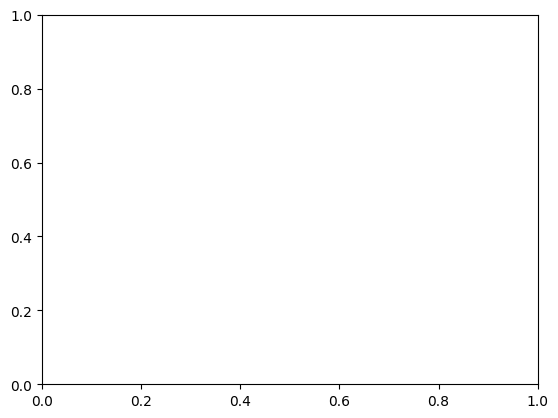

In [145]:
color_map = {
    'Semitic': 'red',
    'isolate': 'blue',
    'Indo-European-Romance': 'green',
    'Indo-European-Baltoslavic': 'orange',
    'Indo-European-Germanic': 'purple',
    'Indo-European': 'yellow',
    'Sino-Austronesian': 'black',
    'Agglutinating': 'gray'
}

xs = []
ys = []
cs = []
labels = []

for k in models.keys():
    if k in surprisals and k in flexibility:
        xs.append(flexibility[k])
        ys.append(surprisals[k])
        cs.append(color_map[groups[k]])
        labels.append(groups[k])
        print(k, xs[-1], ys[-1])

plt.scatter(xs, ys, color=cs)#, label=cs)
plt.legend()

In [83]:
scipy.stats.linregress(xs, ys)

LinregressResult(slope=0.06744395534459495, intercept=6.640287723851007, rvalue=0.29979643964875496, pvalue=0.19907746324273742, stderr=0.05058597645888903, intercept_stderr=1.0431591952684278)

In [162]:
def graph(flex_file, surp_k):
    flex_data = json.load(open(flex_file, "r"))
    flexibility = {i['data'][0]['label']: i['data'][0]['y'] for i in flex_data}
    groups = {i['data'][0]['label']: i['label'][0].split("/")[1] for i in flex_data}
    surprisals = {}
    for k in models.keys():
        try:
            surprisals[k] = float(open(f'surprisals-{surp_k}-{k}.txt').read().split()[1])
        except Exception as e:
            print(k, e)

    color_map = {
        'Semitic': 'red',
        'isolate': 'blue',
        'Indo-European-Romance': 'green',
        'Indo-European-Baltoslavic': 'orange',
        'Indo-European-Germanic': 'purple',
        'Indo-European': 'yellow',
        'Sino-Austronesian': 'black',
        'Agglutinating': 'gray'
    }
    
    xs = []
    ys = []
    cs = []
    labels = []
    
    for k in models.keys():
        if k in surprisals and k in flexibility and k != 'Bulgarian':
            xs.append(flexibility[k])
            ys.append(surprisals[k])
            cs.append(color_map[groups[k]])
            labels.append(groups[k])
            print(k, xs[-1], ys[-1])
    
    plt.scatter(xs, ys, color=cs)#, label=cs)
    plt.legend()

    return scipy.stats.linregress(xs, ys)

Arabic 9.03 4.04563453238125
Basque 35.78 11.776336400187533
Belarusian 25.78 6.118578286097173
Catalan 13.72 9.052308156371192
Chinese 11.77 4.923433337567701
Croatian 25.8 10.880824251416206
Czech 30.19 7.109270836080594
Danish 26.22 6.005561456922288
Dutch 31.73 8.102134119309605
English 13.16 5.385080123613887
Estonian 44.76 13.642515598999879
Finnish 37.02 8.721606240669887
French 14.09 11.2084986283827
German 32.94 9.493257881042421
Hebrew 18.41 9.138165437146084
Hindi 1.59 5.446858579018244
Indonesian 18.69 9.125195615680122
Irish 9.63 9.57934247551619
Italian 18.1 6.43303417319251
Japanese 0.45 1.825211022554627
Korean 5.43 6.814609626414776
Norwegian 21.44 6.307626848306947
Persian 16.06 6.451482465428169
Polish 34.73 10.081362574953527
Portuguese 14.15 6.349698236746741
Romanian 26.36 6.267452599230702
Russian 28.79 4.862853204450294
Slovenian 27.58 9.071584160015092
Spanish 16.61 7.127142944834537
Turkish 3.61 10.056914489134401
Armenian 33.02 1.6996222968809394
Greek 16.4 6

/var/folders/my/xjpgt3ss01991yghb67xgjs80000gn/T/ipykernel_99497/3336845974.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


LinregressResult(slope=0.08132668227797127, intercept=5.576713853787666, rvalue=0.33277181042529985, pvalue=0.05078649188374131, stderr=0.04011849647924051, intercept_stderr=0.9460029892444006)

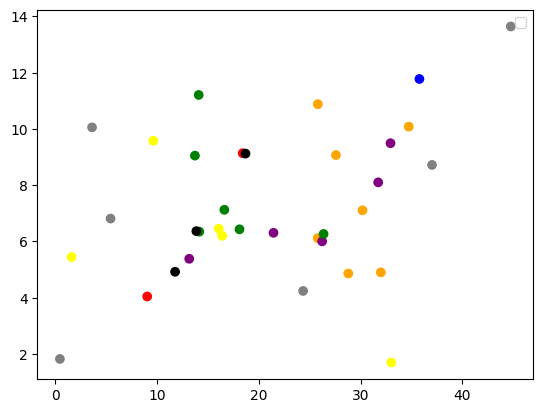

In [186]:
graph("flexibility_ any.json", 3)